In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import csv
import numpy
from decimal import Decimal
import scipy
import pylab
from sklearn.linear_model import LinearRegression
%matplotlib inline

plt.rcParams['figure.figsize']=(7,6)
plt.rcParams['axes.titlesize']=16
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['legend.edgecolor']='k'

import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator

class Molecule:
    def __init__(self):
                self.kB= 1.380649e-23 #ct.boltzmann units: m2kg/s2/K
                self.h= 6.62607009e-34 #ct.planck units: Js
                self.R= 8.3144621E-3 #ct.gas_constant/1e3 units: kJ/mol/K
                self.c = 2.99792458e8 #speed of light in m/s
                self.amu = 1.6605e-27 #atomic mass unit in kg
                self.Avogadro = 6.0221E23 #mole^-1
                self.GHz_to_Hz = 1.0E9 #convert rotational constants from GHz to Hz
                self.invcm_to_invm = 1.0E2 #convert cm^-1 to m^-1, for frequencies
                self.P_ref = 1.0E5 #reference pressure, 1 bar = 1E5 Pascal
                self.hartree_to_kcalpermole = 627.5095 #convert hartree/molecule to kcal/mol
                self.hartree_to_kJpermole = 2627.25677 #convert hartree/molecule to kJ/mol
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.site_occupation_number = 1 #number of sites occupied by adsorbate
                self.unit_cell_area = {'Ni111': 48.55968e-20/9.0, 'Ni100': 56.070144e-20/9.0,'Ni110': 79.29792e-20/9.0, 'Ni211': 45.781632e-20/9.0} #m2 - using surface area per binding site (nine binding sites per cell)
                self.cutoff_frequency = 100.0 #cm^-1
                self.is_twoD_gas = False
                self.tst_twoD_gas = False
                self.molecular_mass_elements={'H': 1.01, 'C': 12.01, 'N': 14, 'O': 16}
                
# create the array of temperatures in 5 degree increments
temperature = [298.15] #NOTE 298.15 must be first for the NASA polynomial routine to work!
T_low = 300
T_high = 1500
dT = 10.0 #temperature increment
temperature = np.append(temperature, np.arange(T_low, T_high+dT, dT) )

# HERE BEGINS THE LONG LIST OF SUBROUTINES
#-------------------------------------------------------------------------
# subroutine for the translational mode
def get_translation_thermo(molecule,temperature):
    # unpack the constants (not essential, but makes it easier to read)
    R = molecule.R
    kB = molecule.kB
    h = molecule.h
    amu = molecule.amu
    P_ref = molecule.P_ref
    #calculate the molecular mass from the composition
    m=molecule.composition['H']*molecule.molecular_mass_elements['H']
    m+=molecule.composition['O']*molecule.molecular_mass_elements['O']
    m+=molecule.composition['C']*molecule.molecular_mass_elements['C']
    m+=molecule.composition['N']*molecule.molecular_mass_elements['N']
    pi = np.pi
    sites = molecule.site_occupation_number

    if molecule.facet == 'Ni111':
        area = molecule.unit_cell_area['Ni111']
    elif molecule.facet == 'Ni100':
        area = molecule.unit_cell_area['Ni100']
    elif molecule.facet == 'Ni110':
        area = molecule.unit_cell_area['Ni110']
    elif molecule.facet == 'Ni211':
        area = molecule.unit_cell_area['Ni211']
    else:
        print('Please provide the right facet!')
    
    #initialize the arrays for the partition function and the entropy
    Q_trans_is  = np.ones(len(temperature)) 
    S_trans_is  = np.zeros(len(temperature))

    if molecule.is_twoD_gas:
        print("switching to 2D-gas for 2 lowest modes for %s"%molecule.name)
        # cycle through each temperature
        for (i,T) in enumerate(temperature):
            # partition function is: (2*pi*mass*kB*T/h**2)^(2/2) * area
            if (1==0): #3D gas, really here just for inspiration
                V = kB*T/P_ref #This is volume per molecule of an ideal gas
                Q_trans_is[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
                S_trans_is[i] = R * (2.5 + np.log( Q_trans_is[i] )) 
            else: #surface
                if (1==0): #Campbell + Arnadottir
                    V = kB*T/P_ref
                    Q_trans_is[i] = (2*pi*m*amu*kB*T/h**2)**(1.0) *V**0.66667
                    S_trans_is[i] = R * (2.0 + np.log( Q_trans_is[i] ))   
                else: #area is not a function of temperature
                    Q_trans_is[i] = (2*pi*m*amu*kB*T/h**2) * area * sites
                    S_trans_is[i] = R * (2.0 + np.log( Q_trans_is[i] ))
       
    # add the results to the thermo object
    molecule.Q_trans_is = Q_trans_is
    molecule.S_trans_is = S_trans_is
    
    #initialize the arrays for the partition function and the entropy
    Q_trans_tst  = np.ones(len(temperature)) 
    S_trans_tst  = np.zeros(len(temperature))

    if molecule.tst_twoD_gas:
        print("switching to 2D-gas for 2 lowest modes for %s"%molecule.name)
        # cycle through each temperature
        for (i,T) in enumerate(temperature):
            # partition function is: (2*pi*mass*kB*T/h**2)^(2/2) * area
            if (1==0): #3D gas, really here just for inspiration
                V = kB*T/P_ref #This is volume per molecule of an ideal gas
                Q_trans_tst[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
                S_trans_tst[i] = R * (2.5 + np.log( Q_trans_tst[i] )) 
            else: #surface
                if (1==0): #Campbell + Arnadottir
                    V = kB*T/P_ref
                    Q_trans_tst[i] = (2*pi*m*amu*kB*T/h**2)**(1.0) *V**0.66667
                    S_trans_tst[i] = R * (2.0 + np.log( Q_trans_tst[i] ))   
                else: #area is not a function of temperature
                    Q_trans_tst[i] = (2*pi*m*amu*kB*T/h**2) * area * sites
                    S_trans_tst[i] = R * (2.0 + np.log( Q_trans_tst[i] ))
       
    # add the results to the thermo object
    molecule.Q_trans_tst = Q_trans_tst
    molecule.S_trans_tst = S_trans_tst
    
    return

# subroutine for the vibrational mode
def get_vibrational_thermo(molecule,temperature):

    units = 1.0
    units *= molecule.h * molecule.c / molecule.kB * molecule. invcm_to_invm # K*cm
    
    #initialize the arrays for the partition function and the entropy
    Q_vib_is  = np.ones(len(temperature))
    S_vib_is  = np.zeros(len(temperature))
    
    for (t,temp) in enumerate(temperature):
        for (n,nu) in enumerate(molecule.is_frequencies):
            if molecule.is_twoD_gas==True and n <= 1: #skip the first two if we do 2D gas
                #do nothing!
                Q_vib_is[t] *= 1.0
                S_vib_is[t] += 0.0
            else:
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib_is[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib_is[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
        S_vib_is[t]  *= molecule.R
    # add the results to the thermo object
    molecule.Q_vib_is = Q_vib_is
    molecule.S_vib_is = S_vib_is
    
    
    #initialize the arrays for the partition function and the entropy
    Q_vib_tst  = np.ones(len(temperature))
    S_vib_tst  = np.zeros(len(temperature))
    
    for (t,temp) in enumerate(temperature):
        for (n,nu) in enumerate(molecule.tst_frequencies):
            if molecule.tst_twoD_gas==True and n <= 1: #skip the first two if we do 2D gas
                #do nothing!
                Q_vib_tst[t] *= 1.0
                S_vib_tst[t] += 0.0
            else:
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib_tst[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib_tst[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
        S_vib_tst[t]  *= molecule.R
    # add the results to the thermo object
    molecule.Q_vib_tst = Q_vib_tst
    molecule.S_vib_tst = S_vib_tst
    
    return

#-------------------------------------------------------------------------
#create the main thermo function that calls the individual modes
def thermo(molecule, temperature):
    
    # call the subroutine for the vibrational partition function
    get_translation_thermo(molecule,temperature)
    get_vibrational_thermo(molecule,temperature)
    
    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q_is = molecule.Q_trans_is * molecule.Q_vib_is
    molecule.S_is = molecule.S_trans_is + molecule.S_vib_is
    
    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q_tst = molecule.Q_trans_tst * molecule.Q_vib_tst
    molecule.S_tst = molecule.S_trans_tst + molecule.S_vib_tst
    
    return

#-------------------------------------------------------------------------
#compare NASA fits to computed fits
def compare_thermo(temperature, molecule):
    
    fig = pylab.figure(dpi=300,figsize=(7,6))
    gs = gridspec.GridSpec(1, 2)
    gs.update(wspace = 0.5)
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[0])

    ax2.semilogy(temperature, molecule.S_is, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None', markersize=5, label='IS')
    ax2.semilogy(temperature, molecule.S_tst, marker='o', markeredgecolor='b',color='w',alpha=0.5,linestyle='None', markersize=5, label='TST')

    ax2.set_ylim(min(molecule.S_tst)*0.9, max(molecule.S_is)*1.025)
    ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))     
        
    ax2.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.tick_params(direction='in', axis='both', which='major', labelsize=12)
    ax2.tick_params(direction='in', axis='both', which='minor')
    ax2.set_title("entropy")
    ax2.set_xlabel("$T\ /\ \mathrm{K}$  ", fontsize=14)
    ax2.set_ylabel("$S\ /\ \mathrm{kJ mol^{-1} K^{-1}}$", fontsize=14)
    plt.legend() 
    
    return
    

    
def get_arrhenius(temperature, molecule):
    
    #This is the difference in entropy between transition state and initial state
    #Subtract the ZPE from SPE
    is_energy=molecule.is_SPE+molecule.is_ZPE
    tst_energy=molecule.tst_SPE+molecule.tst_ZPE

    #The change in the enthalpy of is the difference in the energy of the transition and final state, convert to kJ/mol
    delta_energy=tst_energy-is_energy
    delta_energy*=96.485

    delta_entropy=molecule.S_tst-molecule.S_is
    ratio_q=molecule.Q_tst/molecule.Q_is 
    
    k  = np.zeros(len(temperature))
    temp_reciprok=np.zeros(len(temperature))
    for (t,temp) in enumerate(temperature):
        k[t]=molecule.kB*temp/molecule.h*ratio_q[t]*np.exp(-delta_energy/molecule.R/temp)
        temp_reciprok[t]=1/temp
        
    log_k=np.log(k)
    #Reshape the arrays for the fitting procedure
    log_k=log_k.reshape(len(log_k),1)
    temp_reciprok=temp_reciprok.reshape(len(temp_reciprok),1)

    
    #Linear regression of an Arrhenius expression to the calculated rate constant
    model =LinearRegression(fit_intercept=True)
    model.fit(temp_reciprok,log_k)
    yfit=model.predict(log_k)
    Ea_R=float(model.coef_[0])
    ln_A=float(model.intercept_[0])
    Ea=molecule.R*-Ea_R
    A=np.exp(ln_A)
    score=model.score(temp_reciprok,log_k)
    
    Fit=A*np.exp(-Ea/molecule.R*temp_reciprok)
    
    
    if molecule.facet == 'Ni111':
        area = molecule.unit_cell_area['Ni111']
    elif molecule.facet == 'Ni100':
        area = molecule.unit_cell_area['Ni100']
    elif molecule.facet == 'Ni110':
        area = molecule.unit_cell_area['Ni110']
    elif molecule.facet == 'Ni211':
        area = molecule.unit_cell_area['Ni211']
    else:
        print('Please provide the right facet!')
    
    Gamma=1/area/molecule.Avogadro/1e4  

    #convert A to right units:
    A_surf = A/(Gamma)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(temp_reciprok, np.log(k), 'ro', label='$\mathrm{k_{TST}}$')
    ax.plot(temp_reciprok, np.log(Fit), 'b', label='$\mathrm{k_{fit}}$')
    
    ax.text(0.1, 0.25, '$\mathrm{A=%.2E\ cm^2/mol/s}$'%(A_surf),
     horizontalalignment='left' ,fontsize=14, transform = ax.transAxes)
    
    ax.text(0.1, 0.2, '$\mathrm{E_a=%.1F\ kJ/mol}$'%(Ea),
     horizontalalignment='left', fontsize=14, transform = ax.transAxes)
    
    ax.legend(loc='best', fontsize=12)
    ax.set_xlabel('1/T (K$^{-1}$)', fontsize=14)
    ax.set_ylabel('$ln(k(T))$', fontsize=14);
    
#-------------------------------------------------------------------------
#This would be a good place to define the input parser
def parse_input_file(inputfile, molecule):
    
    import sys, os
    script_dir='data/'
    rel_path = str(inputfile)
    abs_file_path = os.path.join(script_dir, rel_path)
    
    input_file = open(abs_file_path,'r')
    lines = input_file.readlines()
    input_file.close()
    
    error_name = True
    error_DFT_binding_energy = True
    error_composition = True
    error_sites = True
    error_adsorbate_mass = True
    error_is_frequencies = True
    error_tst_frequencies = True
    error_facet = True

    
    for line in lines:
        #start by looking for the name
        if line.strip().startswith("name"):
            bits = line.split('=')
            name = bits[1].strip().replace("'","").replace('"','')
            molecule.name = name
            error_name = False
        #now look for the DFT energy    
        elif line.strip().startswith("IS_SPE"):
            bits = line.split('=') 
            is_SPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            is_SPE = float(is_SPE_info[0])
            units = is_SPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.is_SPE = is_SPE
                molecule.is_SPE_units = units.strip()
                error_is_SPE = False
            else:
                print ("DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("IS_ZPE"):
            bits = line.split('=') 
            is_ZPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            is_ZPE = float(is_ZPE_info[0])
            units = is_ZPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.is_ZPE = is_ZPE
                molecule.is_ZPE_units = units.strip()
                error_is_ZPE = False
            else:
                print ("ZPE energy is missing proper units!\n Please use 'eV'")
                break
        #now look for the DFT energy    
        elif line.strip().startswith("TST_SPE"):
            bits = line.split('=') 
            tst_SPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            tst_SPE = float(tst_SPE_info[0])
            units = tst_SPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.tst_SPE = tst_SPE
                molecule.tst_SPE_units = units.strip()
                error_tst_SPE = False
            else:
                print ("gas DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("TST_ZPE"):
            bits = line.split('=') 
            tst_ZPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            tst_ZPE = float(tst_ZPE_info[0])
            units = tst_ZPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.tst_ZPE = tst_ZPE
                molecule.tst_ZPE_units = units.strip()
                error_tst_ZPE = False
            else:
                print ("gas ZPE energy is missing proper units!\n Please use 'eV'")
                break
                
        #now look for the composition    
        elif line.strip().startswith("composition"):
            bits = line.split('=') 
            composition = bits[1].strip().replace("{","").replace("}","").split(',')
            molecule.composition = {}
            for pair in composition:
                element, number = pair.split(":")
                element = element.strip().replace("'","").replace('"','')
                number = int(number)
                molecule.composition[element]=number
            N_adsorbate_atoms = 0
            for element in molecule.composition:
                if element!='Pt':
                    N_adsorbate_atoms += molecule.composition[element]            
            error_composition = False
        #now look for the site occupancy    
        elif line.strip().startswith("sites"):
            bits = line.split('=') 
            site_occupation_number = int(bits[1])
            molecule.site_occupation_number = site_occupation_number
            error_sites = False  

        #now look for the frequencies of the transition state   
        elif line.strip().startswith("IS_frequencies"):
            bits = line.split('=')
            is_freq_info = bits[1].strip().replace("[","").replace("]","").split(',')
            N_freq_computed = 3*N_adsorbate_atoms
            if len(is_freq_info)!=N_freq_computed+1:
                print ("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(is_freq_info)-1))
            units = is_freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.frequencies_units = units.strip()
                molecule.is_frequencies = []
                for i in range(len(is_freq_info)-1):
                    molecule.is_frequencies.append(float(is_freq_info[i]))
                error_is_frequencies = False
                #if the two lowest frequencies are less than the cutoff value (This assumes that they are sorted!)
                if molecule.is_frequencies[1]<molecule.cutoff_frequency:
                    #print "switching to 2D-gas for 2 lowest modes for %s"%name
                    molecule.is_twoD_gas = False
                    
        #now look for the facet 
        elif line.strip().startswith("facet"):
            bits = line.split('=') 
            facet_info = bits[1].strip().replace("[","").replace("]","").replace("'","")
            facet = str(facet_info)
            molecule.facet = facet
            error_facet = False
                    
        elif line.strip().startswith("TST_frequencies"):
            bits = line.split('=')
            tst_freq_info = bits[1].strip().replace("[","").replace("]","").split(',')
            N_freq_computed = 3*N_adsorbate_atoms-1
            if len(tst_freq_info)!=N_freq_computed+1:
                print ("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(tst_freq_info)-1))
            units = tst_freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.tst_frequencies_units = units.strip()
                molecule.tst_frequencies = []
                for i in range(len(tst_freq_info)-1):
                    molecule.tst_frequencies.append(float(tst_freq_info[i]))
                error_tst_frequencies = False
                #if the two lowest frequencies are less than the cutoff value (This assumes that they are sorted!)
                if molecule.tst_frequencies[1]<molecule.cutoff_frequency:
                    #print "switching to 2D-gas for 2 lowest modes for %s"%name
                    molecule.tst_twoD_gas = False
                    
    if error_name or error_composition or error_is_frequencies or error_tst_frequencies:
        print ("Input file is missing information: %s"%(inputfile))
    else:
        print ("successfully parsed file %s"%(inputfile))
    
    return                

successfully parsed file Ni110/C-O.dat
successfully parsed file Ni110/OC-O.dat


/var/folders/ct/t72gd9jn14l9bbfml_gschyh0000gn/T/ipykernel_81670/2247431904.py:268: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ea_R=float(model.coef_[0])
/var/folders/ct/t72gd9jn14l9bbfml_gschyh0000gn/T/ipykernel_81670/2247431904.py:268: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ea_R=float(model.coef_[0])


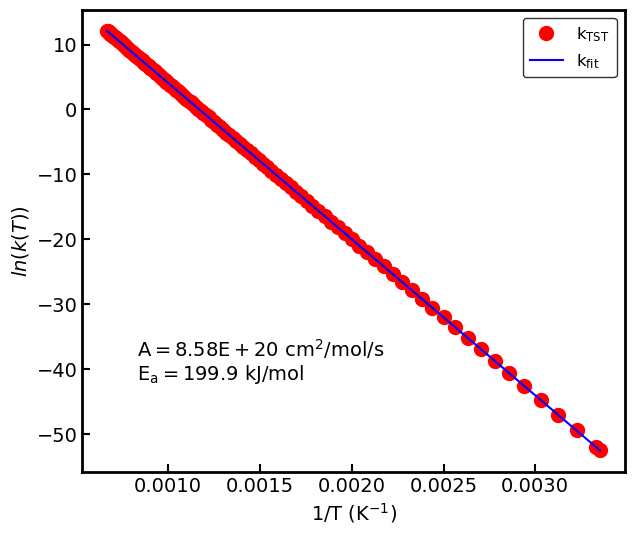

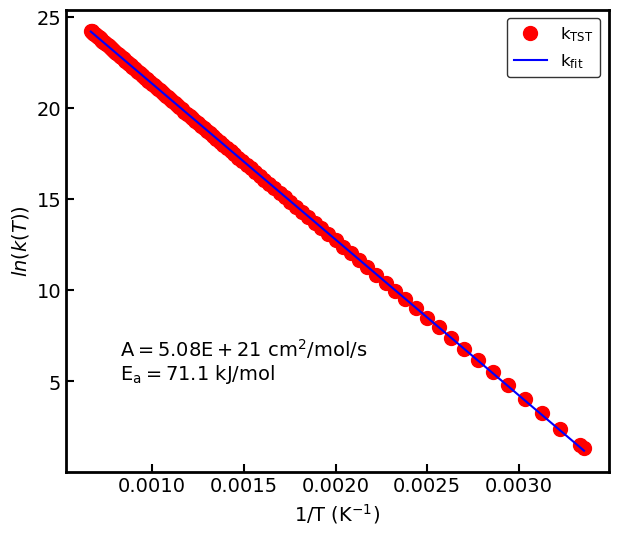

In [6]:
list_of_species = 'species_list.dat'
info = open(list_of_species,'r')
species_list = info.readlines()

info.close()

counter = -1
for species in species_list:
    counter += 1
    filename = species.strip()
    test = Molecule()
    parse_input_file(filename, test)
    thermo(test, temperature)
    get_arrhenius(temperature, test)